# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [58]:
# !pip install pycaret==3.0.2

In [59]:
import pandas as pd
import numpy as np
import requests
#from pprint import pprint
#from bs4 import BeautifulSoup
#import re
#import json
#from urllib.request import Request, urlopen
#from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from pycaret.clustering import *

## DataFrame

In [60]:
# from google.colab import drive
# drive.mount('/content/drive')

#EDA - Exploratory Data Analysis

In [61]:
path_to_export = '/Users/henricobela/Desktop/Estudos/Github/Python/Faculdade/FIAP/Segundo_ano/2o_semestre/AUTOML/Clustering/atividade_clustering/raw_data'
df = pd.read_csv(f'{path_to_export}/all_movies.csv', sep = ';')

df = df[["title_pt", "title_en", "year", "rating", "genre", "sinopse"]]

print(df.shape)
df.head()

(335, 6)


title_pt                           title_en  year  \
0           Um Sonho de Liberdade           1. Um Sonho de Liberdade  1994   
1               O Poderoso Chefão               2. O Poderoso Chefão  1972   
2  Batman: O Cavaleiro das Trevas  3. Batman: O Cavaleiro das Trevas  2008   
3            O Poderoso Chefão II            4. O Poderoso Chefão II  1974   
4        12 Homens e uma Sentença        5. 12 Homens e uma Sentença  1957   

  rating     genre                                            sinopse  
0    9.3     Drama  Dois homens presos se reúnem ao longo de vário...  
1    9.2  Policial  O patriarca idoso de uma dinastia do crime org...  
2    9.0      Ação  Quando a ameaça conhecida como O Coringa surge...  
3    9.0  Policial  Em 1950, Michael Corleone, agora à frente da f...  
4    9.0  Policial  O julgamento de um assassinato em Nova Iorque ...

In [62]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df["rating"] = df["rating"].apply(lambda x: x.split("\xa0")[0] if not isinstance(x, float) else x)
df['rating'] = df['rating'].astype('float64')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_pt  335 non-null    object 
 1   title_en  335 non-null    object 
 2   year      335 non-null    int64  
 3   rating    328 non-null    float64
 4   genre     335 non-null    object 
 5   sinopse   335 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 15.8+ KB


In [64]:
df.describe()

year      rating
count   335.000000  328.000000
mean   1995.483582    7.924085
std      26.832239    0.858203
min    1921.000000    3.200000
25%    1979.000000    8.100000
50%    2002.000000    8.200000
75%    2019.000000    8.325000
max    2024.000000    9.300000

## Plots

In [65]:
df.genre.value_counts('d')

Ação          0.238806
Drama         0.220896
Comédia       0.125373
Policial      0.116418
Animação      0.086567
Biografia     0.074627
Aventura      0.074627
Terror        0.038806
Mistério      0.011940
Faroeste      0.002985
Filme noir    0.002985
Fantasia      0.002985
Suspense      0.002985
Name: genre, dtype: float64

In [66]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

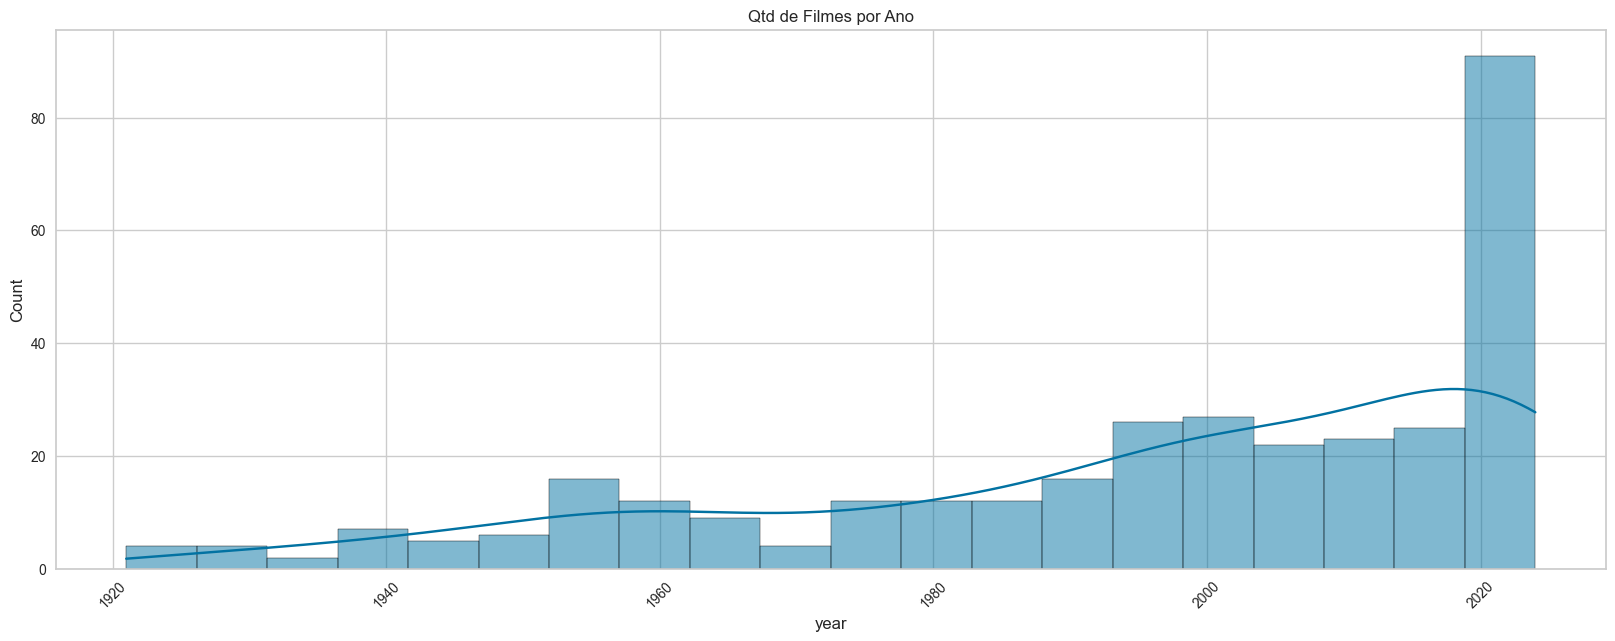

In [67]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True, bins = 20).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

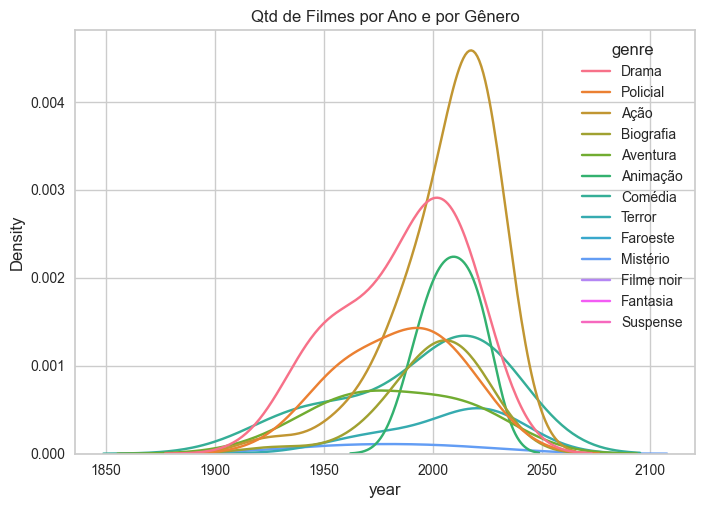

In [68]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [69]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

0    dois homens presos se reúnem ao longo de vário...
1    o patriarca idoso de uma dinastia do crime org...
2    quando a ameaça conhecida como o coringa surge...
3    em 1950, michael corleone, agora à frente da f...
4    o julgamento de um assassinato em nova iorque ...
Name: sinopse, dtype: object

In [70]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [71]:
### Feature Engineering
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt                           title_en  year  \
0           Um Sonho de Liberdade           1. Um Sonho de Liberdade  1994   
1               O Poderoso Chefão               2. O Poderoso Chefão  1972   
2  Batman: O Cavaleiro das Trevas  3. Batman: O Cavaleiro das Trevas  2008   
3            O Poderoso Chefão II            4. O Poderoso Chefão II  1974   
4        12 Homens e uma Sentença        5. 12 Homens e uma Sentença  1957   

   rating     genre                                            sinopse  \
0     9.3     Drama  dois homens presos se reúnem ao longo de vário...   
1     9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
2     9.0      Ação  quando a ameaça conhecida como o coringa surge...   
3     9.0  Policial  em 1950, michael corleone, agora à frente da f...   
4     9.0  Policial  o julgamento de um assassinato em nova iorque ...   

   word_count  
0          21  
1          20  
2          33  
3          41  
4          29

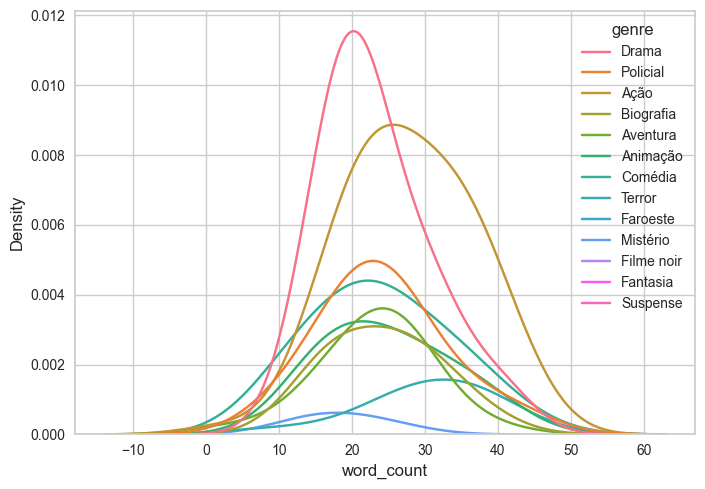

In [72]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover as stopwords

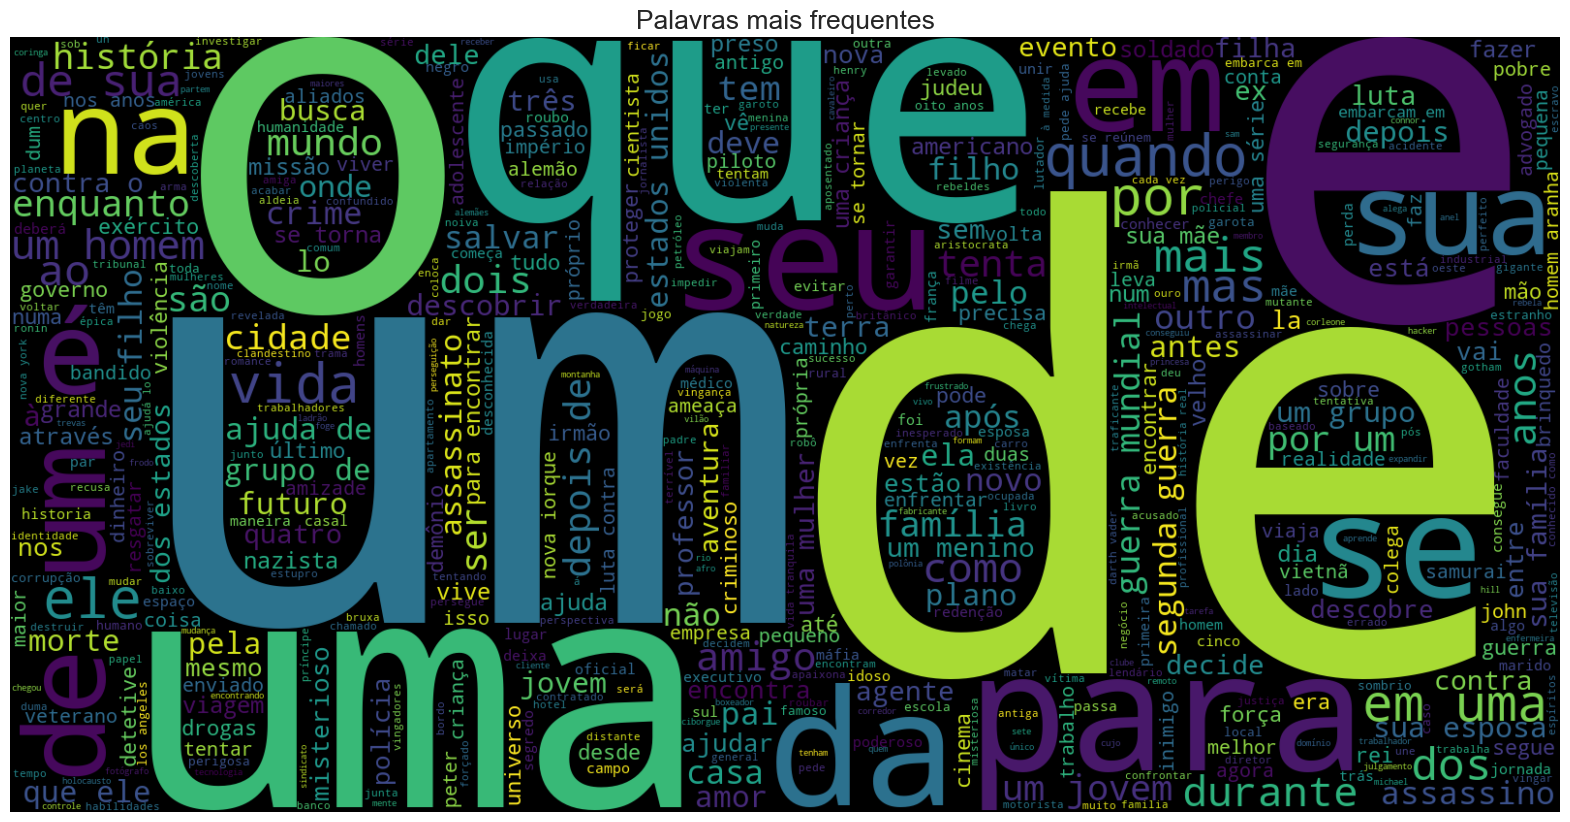

In [73]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [74]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/henricobela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


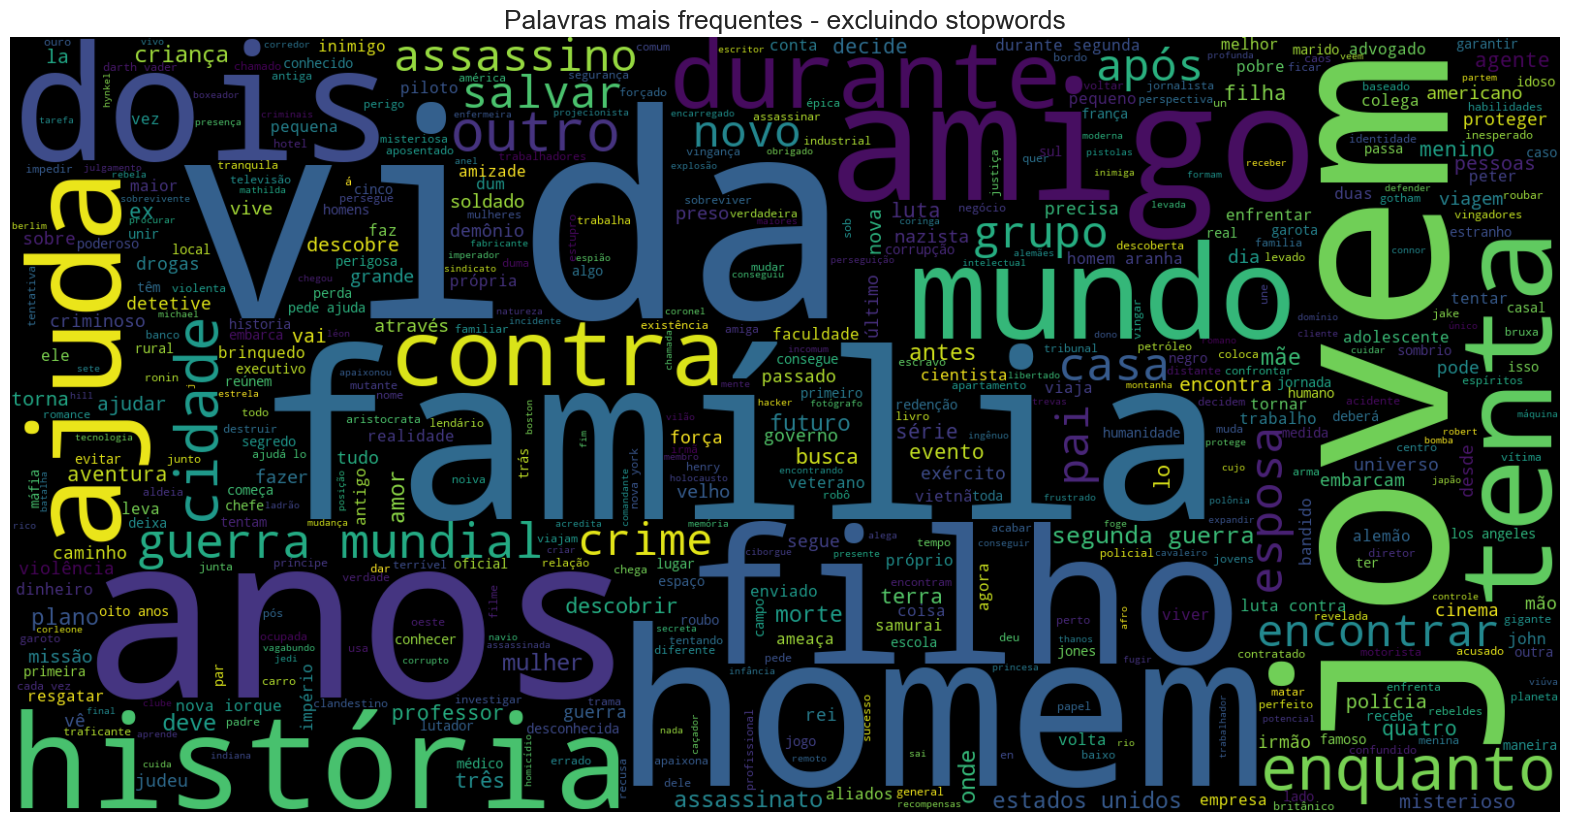

In [75]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF
Term Frequency-Inverse Document Frequency

O TF-IDF define a importância de um termo levando em consideração a importância desse termo em um único documento e dimensionando-o por sua importância em todos os documentos.

In [76]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [77]:
print(X.shape)
X.toarray()

(335, 137)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# AutoML | PyCaret - Clustering

## Setup

In [78]:
s = setup(data = X.toarray(),
          session_id = 123)

# Create Model

In [79]:
mdl_kmeans = create_model('kmeans')

In [80]:
mdl_dbscan = create_model('dbscan')

In [81]:
mdl_meanshift = create_model('meanshift')

# Assign Model

In [82]:
df_kmeans = assign_model(mdl_kmeans)
display(df_kmeans.Cluster.value_counts())
df_kmeans

Cluster 0    251
Cluster 3     31
Cluster 2     30
Cluster 1     23
Name: Cluster, dtype: int64

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          0.0   0.000000        0.0        0.0   0.000000   0.000000   
1          0.0   0.000000        0.0        0.0   0.000000   0.000000   
2          0.0   0.000000        0.0        0.0   0.000000   0.000000   
3          0.0   0.408799        0.0        0.0   0.000000   0.000000   
4          0.0   0.000000        0.0        0.0   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
330        0.0   0.000000        0.0        0.0   0.000000   0.000000   
331        0.0   0.000000        0.0        0.0   0.000000   0.000000   
332        0.0   0.000000        0.0        0.0   0.400586   0.400586   
333        0.0   0.000000        0.0        0.0   0.000000   0.000000   
334        0.0   0.000000        0.0        0.0   0.000000   0.000000   

     feature_7  feature_8  feature_9  feature_10  ...  feature_129  \
0      0.00000        0.0        0.0         0.0  ...          0.0   
1      0.00000        0.0        0.0         0.0  ...          0.0   
2      0.53447        0.0        0.0         0.0  ...          0.0   
3      0.00000        0.0        0.0         0.0  ...          0.0   
4      0.00000        0.0        0.0         0.0  ...          0.0   
..         ...        ...        ...         ...  ...          ...   
330    0.00000        0.0        0.0         0.0  ...          0.0   
331    0.00000        0.0        0.0         0.0  ...          0.0   
332    0.00000        0.0        0.0         0.0  ...          0.0   
333    0.00000        0.0        0.0         0.0  ...          0.0   
334    0.00000        0.0        0.0         0.0  ...          0.0   

     feature_130  feature_131  feature_132  feature_133  feature_134  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
330          0.0          0.0          0.0          0.0          0.0   
331          0.0          0.0          0.0          0.0          0.0   
332          0.0          0.0          0.0          0.0          0.0   
333          0.0          0.0          0.0          0.0          0.0   
334          0.0          0.0          0.0          0.0          0.0   

     feature_135  feature_136  feature_137    Cluster  
0            0.0          0.0          0.0  Cluster 0  
1            0.0          0.0          0.0  Cluster 0  
2            0.0          0.0          0.0  Cluster 0  
3            0.0          0.0          0.0  Cluster 0  
4            0.0          0.0          0.0  Cluster 0  
..           ...          ...          ...        ...  
330          0.0          0.0          0.0  Cluster 0  
331          0.0          0.0          0.0  Cluster 0  
332          0.0          0.0          0.0  Cluster 3  
333          0.0          0.0          0.0  Cluster 0  
334          0.0          0.0          0.0  Cluster 0  

[335 rows x 138 columns]

In [83]:
df_db = assign_model(mdl_dbscan)
df_db.Cluster.value_counts()

Cluster -1    323
Cluster 0      12
Name: Cluster, dtype: int64

In [84]:
df_meanshift = assign_model(mdl_meanshift)
df_meanshift.Cluster.value_counts()

Cluster 0    335
Name: Cluster, dtype: int64

# Analyze Models

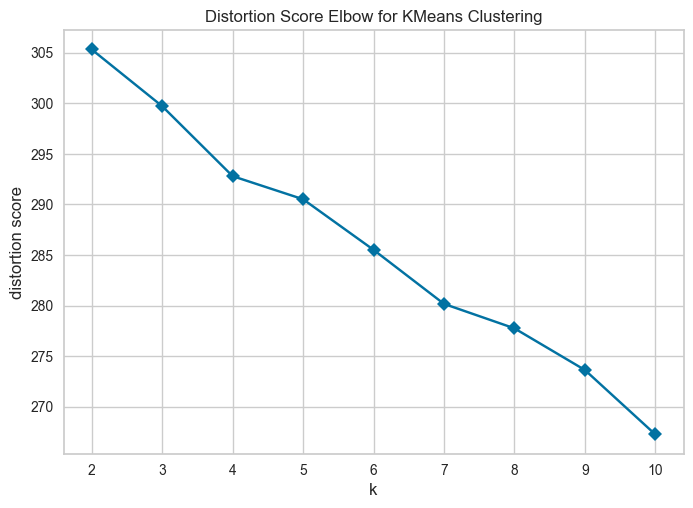

In [85]:
plot_model(mdl_kmeans, plot = 'elbow')

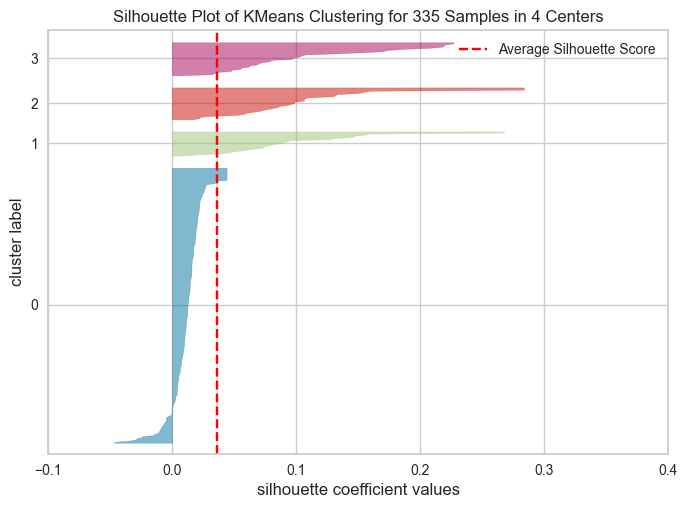

In [86]:
plot_model(mdl_kmeans, plot = 'silhouette')

In [87]:
plot_model(mdl_kmeans, plot = 'distribution')

In [88]:
plot_model(mdl_kmeans, plot = 'cluster')

In [89]:
plot_model(mdl_kmeans, plot = 'tsne')

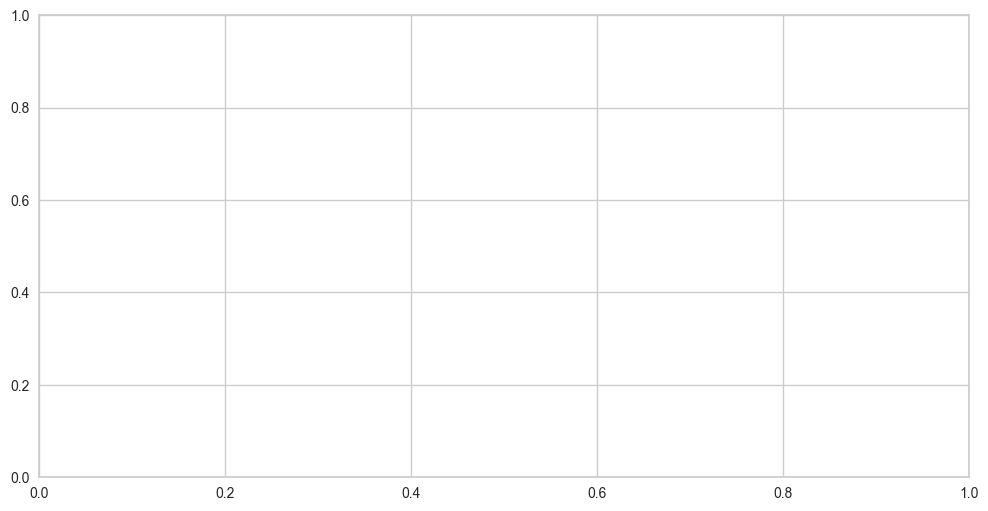

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [90]:
evaluate_model(mdl_kmeans)

# Filmes por cluster

In [91]:
df_processed['cluster'] = df_kmeans['Cluster']
df_processed

title_pt                           title_en  year  \
0             Um Sonho de Liberdade           1. Um Sonho de Liberdade  1994   
1                 O Poderoso Chefão               2. O Poderoso Chefão  1972   
2    Batman: O Cavaleiro das Trevas  3. Batman: O Cavaleiro das Trevas  2008   
3              O Poderoso Chefão II            4. O Poderoso Chefão II  1974   
4          12 Homens e uma Sentença        5. 12 Homens e uma Sentença  1957   
..                              ...                                ...   ...   
330                Duna: Parte Dois                   Duna: Parte Dois  2024   
331                    O Rei Macaco                       O Rei Macaco  2023   
332                         Dunkirk                            Dunkirk  2017   
333            Guardiões da Galáxia               Guardiões da Galáxia  2014   
334                         Titanic                            Titanic  1997   

     rating     genre                                            sinopse  \
0       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
1       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
2       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
3       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
4       9.0  Policial  o julgamento de um assassinato em nova iorque ...   
..      ...       ...                                                ...   
330     NaN      Ação  um menino se torna o messias dos nômades em um...   
331     5.8  Animação  segue um macaco cheio de carisma e seu bastão ...   
332     7.8      Ação  soldados aliados da bélgica, do império britân...   
333     8.0      Ação  um grupo de criminosos intergalácticos deve se...   
334     7.9     Drama  uma aristocrata de dezessete anos se apaixona ...   

     word_count                               sinopse_no_stopwords    cluster  
0            21  dois homens presos reúnem longo vários anos, e...  Cluster 0  
1            20  patriarca idoso dinastia crime organizado tran...  Cluster 0  
2            33  ameaça conhecida coringa surge passado, causa ...  Cluster 0  
3            41  1950, michael corleone, agora frente família, ...  Cluster 0  
4            29  julgamento assassinato nova iorque frustrado ú...  Cluster 0  
..          ...                                                ...        ...  
330          21  menino torna messias nômades planeta deserto, ...  Cluster 0  
331          34  segue macaco cheio carisma bastão mágico. dois...  Cluster 0  
332          25  soldados aliados bélgica, império britânico fr...  Cluster 3  
333          20  grupo criminosos intergalácticos deve unir imp...  Cluster 0  
334          20  aristocrata dezessete anos apaixona artista ge...  Cluster 0  

[335 rows x 9 columns]

## % de Gêneros por Cluster

In [92]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

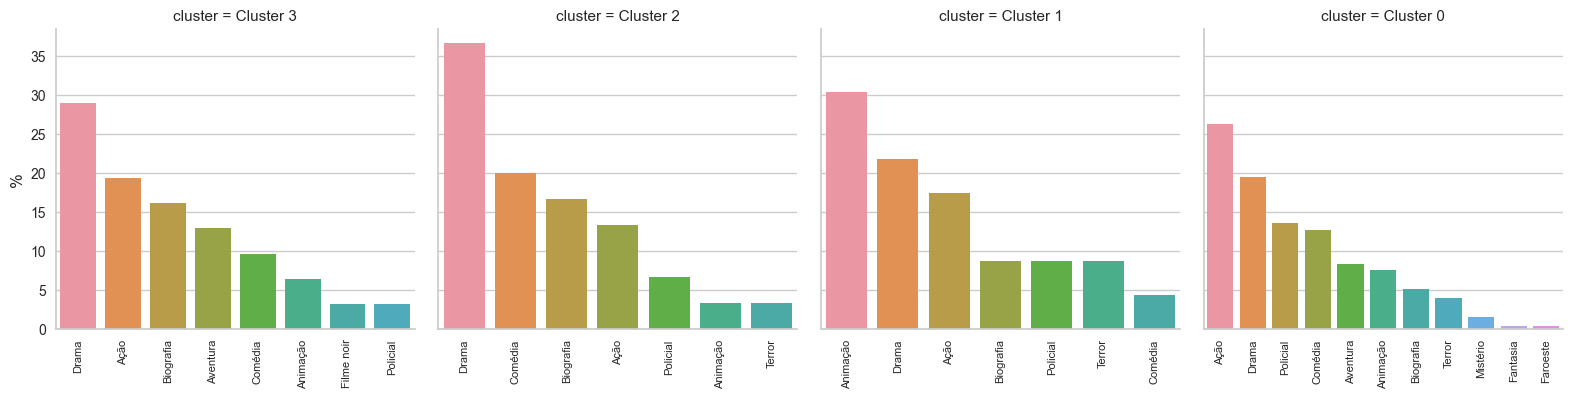

In [93]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

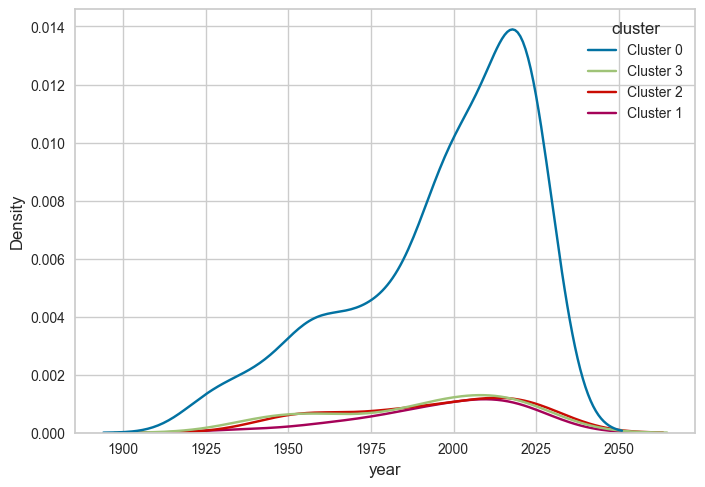

In [94]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [95]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação   7.569721  30.434783   3.333333   6.451613
1          Aventura   8.366534   0.000000   0.000000  12.903226
2              Ação  26.294821  17.391304  13.333333  19.354839
3         Biografia   5.179283   8.695652  16.666667  16.129032
4           Comédia  12.749004   4.347826  20.000000   9.677419
5             Drama  19.521912  21.739130  36.666667  29.032258
6          Fantasia   0.398406   0.000000   0.000000   0.000000
7          Faroeste   0.398406   0.000000   0.000000   0.000000
8        Filme noir   0.000000   0.000000   0.000000   3.225806
9          Mistério   1.593625   0.000000   0.000000   0.000000
10         Policial  13.545817   8.695652   6.666667   3.225806
11           Terror   3.984064   8.695652   3.333333   0.000000

In [96]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0   7.569721
1   Aventura  Cluster 0   8.366534
2       Ação  Cluster 0  26.294821
3  Biografia  Cluster 0   5.179283
4    Comédia  Cluster 0  12.749004

In [97]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

# Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 0


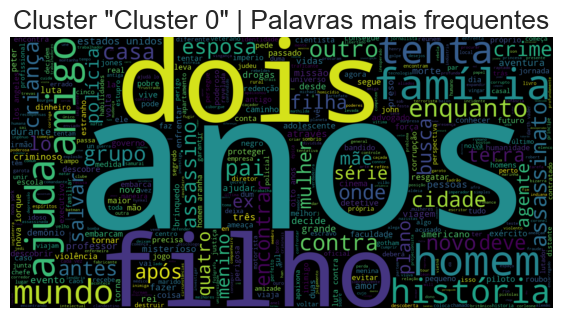

Cluster 3


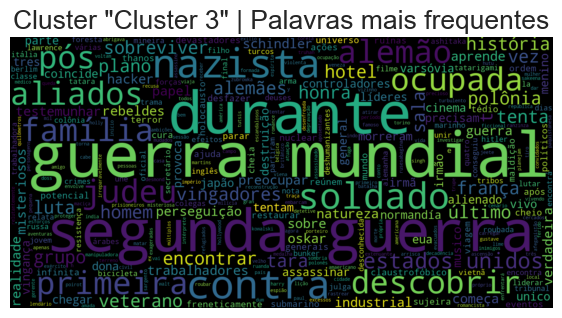

Cluster 2


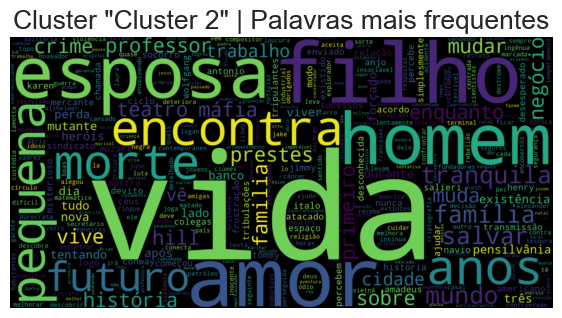

Cluster 1


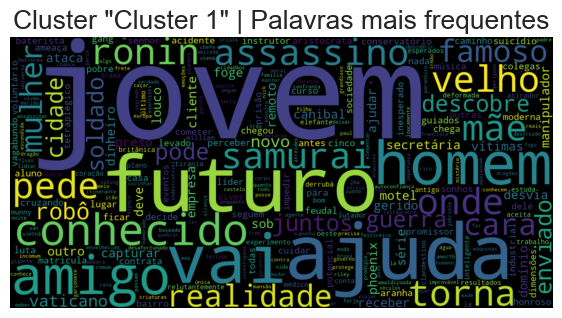

In [98]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

#Conclusões

In [99]:
#Escreva aqui as suas análises / conclusões

# Adicionando demais features do df all_movies ao X

In [100]:
pd.DataFrame(X.toarray()).shape

(335, 137)

In [101]:
df_processed.shape

(335, 9)

In [102]:
df_all = pd.concat([
                    df_processed.drop('cluster', axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all

title_pt                           title_en  year  \
0             Um Sonho de Liberdade           1. Um Sonho de Liberdade  1994   
1                 O Poderoso Chefão               2. O Poderoso Chefão  1972   
2    Batman: O Cavaleiro das Trevas  3. Batman: O Cavaleiro das Trevas  2008   
3              O Poderoso Chefão II            4. O Poderoso Chefão II  1974   
4          12 Homens e uma Sentença        5. 12 Homens e uma Sentença  1957   
..                              ...                                ...   ...   
330                Duna: Parte Dois                   Duna: Parte Dois  2024   
331                    O Rei Macaco                       O Rei Macaco  2023   
332                         Dunkirk                            Dunkirk  2017   
333            Guardiões da Galáxia               Guardiões da Galáxia  2014   
334                         Titanic                            Titanic  1997   

     rating     genre                                            sinopse  \
0       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
1       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
2       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
3       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
4       9.0  Policial  o julgamento de um assassinato em nova iorque ...   
..      ...       ...                                                ...   
330     NaN      Ação  um menino se torna o messias dos nômades em um...   
331     5.8  Animação  segue um macaco cheio de carisma e seu bastão ...   
332     7.8      Ação  soldados aliados da bélgica, do império britân...   
333     8.0      Ação  um grupo de criminosos intergalácticos deve se...   
334     7.9     Drama  uma aristocrata de dezessete anos se apaixona ...   

     word_count                               sinopse_no_stopwords    0  \
0            21  dois homens presos reúnem longo vários anos, e...  0.0   
1            20  patriarca idoso dinastia crime organizado tran...  0.0   
2            33  ameaça conhecida coringa surge passado, causa ...  0.0   
3            41  1950, michael corleone, agora frente família, ...  0.0   
4            29  julgamento assassinato nova iorque frustrado ú...  0.0   
..          ...                                                ...  ...   
330          21  menino torna messias nômades planeta deserto, ...  0.0   
331          34  segue macaco cheio carisma bastão mágico. dois...  0.0   
332          25  soldados aliados bélgica, império britânico fr...  0.0   
333          20  grupo criminosos intergalácticos deve unir imp...  0.0   
334          20  aristocrata dezessete anos apaixona artista ge...  0.0   

            1  ...  127  128  129  130  131  132  133  134  135  136  
0    0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2    0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3    0.408799  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4    0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
330  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
331  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
332  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
333  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
334  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[335 rows x 145 columns]

# Setup

In [103]:
s = setup(data = df_all,
          session_id = 123)

In [104]:
mdl_kmeans_all = create_model('kmeans')

# Evaluate Model

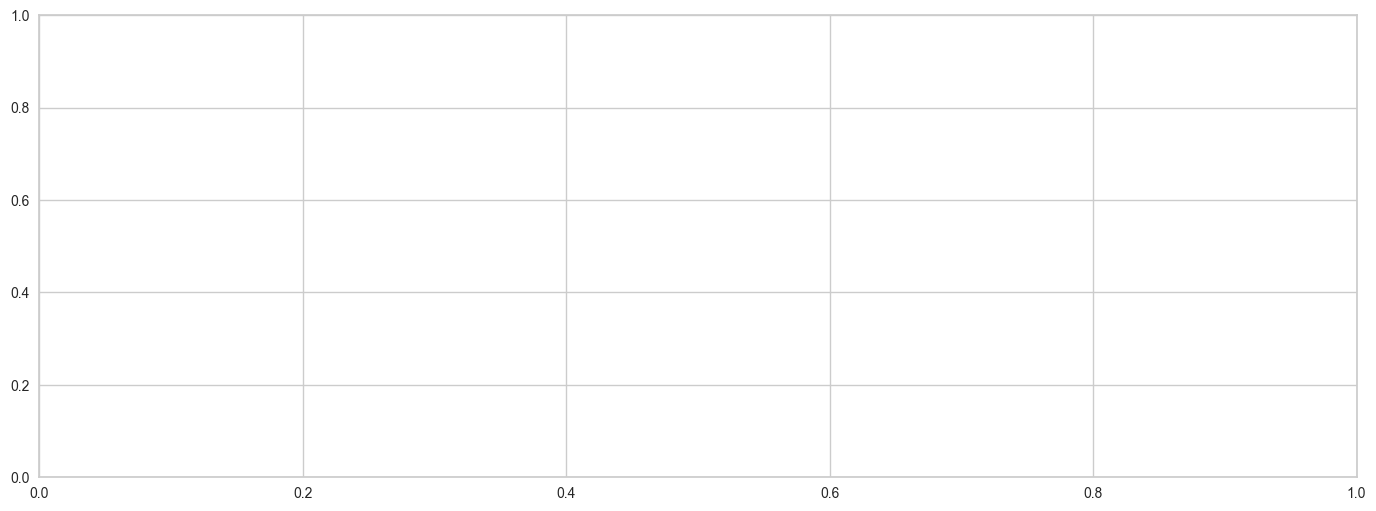

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [105]:
evaluate_model(mdl_kmeans_all)